# Google Earth Engine (GEE) DisALEXI 
## Validation Asset Example

Example of calling GEE DisALEXI function using the validation assets for a small area of Landsat scene LC08_028031_20140708 in eastern Nebraska.  The validation assets were converted to 64bit floats, scaled to appropriate units/ranges, and ingested into Earth Engine.

Examples of the validation assets can be seen here:
https://code.earthengine.google.com/0466eb6dc63732e5b16d687e0091a632

### Python imports and GEE initialization

In [1]:
import os
import pprint
import sys

import ee
from IPython.display import Image

import openet.disalexi.disalexi as eedisalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

In [2]:
pp = pprint.PrettyPrinter(indent=2)
ee.Initialize()

In [3]:
# AmeriFlux sites adjusted to nearest Landsat cell centroid
# http://sites.ameriflux.lbl.gov/US-NE1/
ne1_xy = [-96.47672812080845, 41.16506126041818]
ne2_xy = [-96.46994024736414, 41.16491226772292]
ne3_xy = [-96.43968912903934, 41.17964494123755]
ne1_geom = ee.Geometry.Point(ne1_xy)
ne2_geom = ee.Geometry.Point(ne2_xy)
ne3_geom = ee.Geometry.Point(ne3_xy)

asset_region = [[-96.99, 41.05], [-96.97, 41.86], [-95.89, 41.83], [-95.92, 41.02]]
test_region = [[-96.5, 41.15], [-96.5, 41.2], [-96.41, 41.2], [-96.41, 41.15]]

In [4]:
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
ndvi_palette = '#EFE7E1,#003300'

### Initialized a "prepped" Landsat image

In [5]:
# Setup the image times for joining to the various ancillary collections
# Time_start is 2014-07-08 17:05:50.5502040 UTC
img_time = ee.Date(1404839150550)
img_hour = ee.Date('2014-07-08T17:00', 'GMT')
img_date = ee.Date('2014-07-08', 'GMT')
print('Time Start: {} -> {}'.format(
    img_time.millis().getInfo(), 
    img_time.format('yyyy-MM-dd HH:mm').getInfo()))
print('Hour Start: {} -> {}'.format(
    img_hour.millis().getInfo(), 
    img_hour.format('yyyy-MM-dd HH:mm').getInfo()))
print('Date Start: {} -> {}'.format(
    img_date.millis().getInfo(),
    img_date.format('yyyy-MM-dd HH:mm').getInfo()))

Time Start: 1404839150550 -> 2014-07-08 17:05
Hour Start: 1404838800000 -> 2014-07-08 17:00
Date Start: 1404777600000 -> 2014-07-08 00:00


The following will bypass initializing and prepping a Landsat TOA image and instead build a prepped image directly from the validation assets.

In [6]:
asset_ws = 'users/cgmorton/disalexi/LC08_028031_20140708/'

# Initialize a "prepped" Landsat image using the validation assets directly
input_img = ee.Image([
        ee.Image(asset_ws + 'albedo').rename(['albedo']),
        ee.Image(asset_ws + 'cfmask').rename(['cfmask']),
        ee.Image(asset_ws + 'lai').rename(['lai']),
        ee.Image(asset_ws + 'lst').add(0.01).rename(['lst']),
        ee.Image(asset_ws + 'ndvi').rename(['ndvi'])])
input_img = ee.Image(input_img.set({
    'system:time_start': img_time.millis(),
    'SCENE_ID': 'LC08_028031_20140708'})) 

Show the NDVI band for the full validation asset area

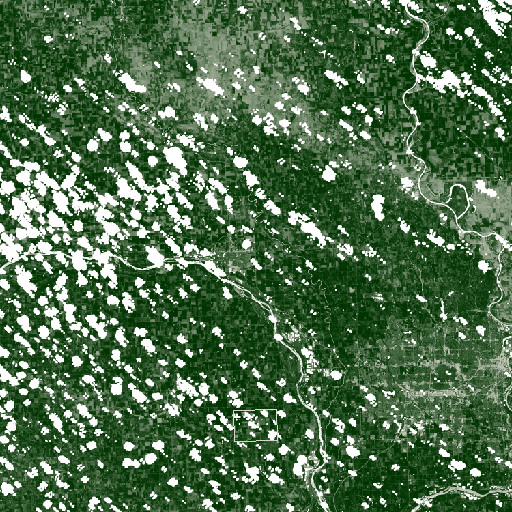

In [7]:
Image(url=input_img.select(['ndvi'])
        .paint(ee.Geometry.Polygon(test_region), 'red', 1)
        .getThumbUrl({'min':-0.1, 'max':0.9, 'palette': ndvi_palette}), 
      embed=True, format='png')

Show the NDVI band for the test site area

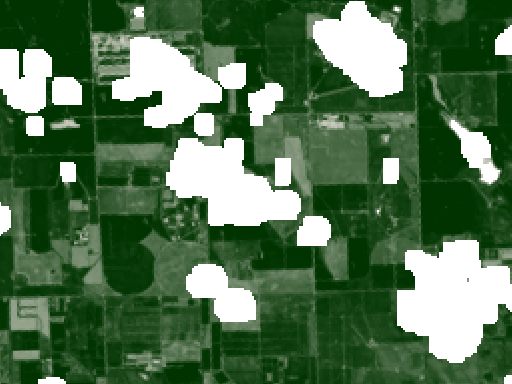

In [8]:
Image(url=input_img.select(['ndvi']).getThumbURL({
        'region': test_region, 'min':-0.1, 'max':0.9, 'palette': ndvi_palette}), 
      embed=True, format='png')

### Extract input values at the test point

In [9]:
print('LAI:    {:12.8f}'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['lai'])))
print('NDVI:   {:12.8f}'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['ndvi'])))
print('Albedo: {:12.8f}'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['albedo'])))
print('LST:    {:12.8f} [K]'.format(float(
    utils.image_value(input_img, xy=ne1_xy)['lst'])))

LAI:      2.82700014
NDVI:     0.84600002
Albedo:   0.19908118
LST:    302.49074951 [K]


### Initialize the DisALEXI object

Eventually it will be possible to set some or all of the anciallary datasets directly when the class is built, but for now, only elevation and landcover are supported.

In [10]:
# Initialize the DisALEXI object
disalexi = eedisalexi.Image(
    input_img, 
    iterations=10,
    elevation=ee.Image.constant(350.0),
    landcover=ee.Image(asset_ws + 'landcover'), lc_type='NLCD')

# Overwrite the ALEXI ET collection with the test asset, geotransform, and crs
# ALEXI ET is filtered to the nearest UTC date
disalexi.et_coll = ee.ImageCollection([
    ee.Image(asset_ws + 'alexiET') \
        .set({'system:time_start': img_date.millis()})])
disalexi.et_transform = [0.04, 0, -125.042123, 0, -0.04, 49.7764322]
disalexi.et_crs = 'EPSG:4326'

# Overwrite the solar data images with the test assets
# # ALEXI ET hourly is filtered to the nearest UTC hour
# disalexi.rs_hourly_coll = ee.ImageCollection([
#     ee.Image(asset_ws + 'Insol1') \
#         .set({'system:time_start': img_hour.millis()})])
# ALEXI ET hourly is interpolated (assume image time is 30 minutes earlier) 
disalexi.rs_hourly_coll = ee.ImageCollection([
    ee.Image(asset_ws + 'Insol1') \
        .set({'system:time_start': img_hour.advance(-1, 'hour').millis()}),
    ee.Image(asset_ws + 'Insol1') \
        .set({'system:time_start': img_hour.millis()})])
# ALEXI ET daily is filtered to the nearest UTC date
disalexi.rs_daily_coll = ee.ImageCollection([
    ee.Image(asset_ws + 'Insol24') \
        .set({'system:time_start': img_date.millis()})])

# Overwrite the weather data images with the test assets
# Wind is filtered to the nearest UTC date
# Create wind as u and v components
disalexi.windspeed_coll = ee.ImageCollection([
    ee.Image([ee.Image(asset_ws + 'u'), ee.Image(asset_ws + 'u').multiply(0)]) \
        .set({'system:time_start': img_date.millis()})
])

### Extract the ancillary values at the test point

In [11]:
disalexi._set_alexi_et_vars()
disalexi._set_elevation_vars()
disalexi._set_landcover_vars()
disalexi._set_solar_vars()
disalexi._set_weather_vars()
print('ALEXI ET:   {:>12.8f} [mm]'.format(float(utils.image_value(
    disalexi.alexi_et, xy=ne1_xy)['alexi_et'])))
print('Elevation:  {:>12.8f} [m]'.format(float(utils.image_value(
    disalexi.elevation, xy=ne1_xy)['elevation'])))
print('Rs Hourly:  {:>12.8f} [W m-2]'.format(float(utils.image_value(
    disalexi.rs1, xy=ne1_xy)['rs'])))
print('Rs Daily:  {:>13.8f} [W m-2]'.format(float(utils.image_value(
    disalexi.rs24, xy=ne1_xy)['rs'])))
print('Wind Speed: {:>12.8f} [m/s]'.format(float(utils.image_value(
    disalexi.windspeed, xy=ne1_xy)['windspeed'])))
print('Land Cover: {:3}'.format(int(utils.image_value(
    disalexi.landcover, xy=ne1_xy)['landcover'])))

ALEXI ET:     5.99517632 [mm]
Elevation:  350.00000000 [m]
Rs Hourly:  917.87847900 [W m-2]
Rs Daily:  8559.06640625 [W m-2]
Wind Speed:   7.02662325 [m/s]
Land Cover:  82


### Compute Air Temperature

Compute the extent of the image for generating the thumbnails

In [12]:
image_crs = ee.Image(asset_ws + 'albedo').projection().crs().getInfo()
image_geom = ee.Image(asset_ws + 'albedo').geometry()

image_transform = ee.Image(asset_ws + 'albedo').projection().getInfo()['transform']
# Reduce the computation resoultion
# image_transform = [120.0, 0.0, 696915.0, 0.0, -120.0, 4587525.0]
print(image_crs)
print(image_transform)

EPSG:32614
[30.0, 0.0, 668565.0, 0.0, -30.0, 4636125.0]


In [13]:
t_air_img = disalexi.compute_ta() \
    .reproject(crs=image_crs, crsTransform=image_transform)

In [14]:
# print('Output Ta: {}'.format(pprint.pformat(
#     utils.image_value(t_air_img, xy=ne1_xy)['t_air'])))

In [15]:
t_air_url = t_air_img.getThumbURL({
    'region': test_region, 'min': 280, 'max':310})
print(t_air_url)

https://earthengine.googleapis.com/api/thumb?thumbid=e301c9145b20587781f2643b23fb85fb&token=4ddf2ebdd2d5561f022caf21da90df5f


In [16]:
Image(url=t_air_url)

### Aggregate Air Temperature to ALEXI ET cells

In [17]:
t_air_coarse_img = disalexi.aggregate(t_air_img)

In [18]:
# print('Coarse Ta: {}'.format(pprint.pformat(
#     utils.image_value(t_air_coarse_img, xy=ne1_xy, scale=1)['t_air'])))

In [34]:
# t_air_coarse_url = url=t_air_coarse_img.getThumbURL({
#     'region': test_region, 'min': 280, 'max':310})
# print(t_air_coarse_url)

In [35]:
# Image(url=t_air_coarse_url)

### Compute ET

In [21]:
et_img = disalexi.compute_et(t_air_coarse_img)

In [22]:
# print('ET: {}'.format(pprint.pformat(
#     utils.image_value(et_img, xy=ne1_xy)['et'])))

In [36]:
# et_url = et_img.getThumbURL({
#     'region': test_region, 'min': 0, 'max': 8, 
#     'palette': ','.join(ssebop_et_palette)})
# print(et_url)

In [37]:
# Image(url=et_url)

### Aggregate ET to ALEXI ET cells

In [25]:
et_coarse_img = disalexi.aggregate(et_img)

In [26]:
# print('Coarse ET: {}'.format(pprint.pformat(
#     utils.image_value(et_coarse_img, xy=ne1_xy, scale=1)['et'])))

### ALEXI ET

In [27]:
# alexi_url = ee.Image(asset_ws + 'alexiET') \
#     .getThumbURL({
#         'region': test_region, 'min': 0, 'max': 8, 
#         'palette': ','.join(ssebop_et_palette)})
# #     .reproject(crs='EPSG:4326') \
# print(alexi_url)

In [28]:
# Image(url=alexi_url, embed=True, format='png')

### Exports

In [29]:
tair_task = ee.batch.Export.image.toDrive(
    t_air_img,
    description='LC08_028031_20140708_asset_tair',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_asset_tair',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [30]:
tair_coarse_task = ee.batch.Export.image.toDrive(
    t_air_coarse_img,
    description='LC08_028031_20140708_asset_tair_coarse',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_asset_tair_coarse',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [31]:
et_task = ee.batch.Export.image.toDrive(
    et_img,
    description='LC08_028031_20140708_asset_et',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_asset_et',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [32]:
et_coarse_task = ee.batch.Export.image.toDrive(
    et_coarse_img,
    description='LC08_028031_20140708_asset_et_coarse',
    folder='DisALEXI',
    fileNamePrefix='LC08_028031_20140708_asset_et_coarse',
    dimensions='3000x3000',
    crs=image_crs,
    crsTransform=image_transform,
    maxPixels=1E9)

In [33]:
# tair_task.start()
# tair_coarse_task.start()
# et_task.start()
# et_coarse_task.start()
# print('Tair Status:        {}'.format(tair_task.status()))
# print('Tair Coarse Status: {}'.format(tair_coarse_task.status()))
# print('ET Status:          {}'.format(et_task.status()))
# print('ET Status:          {}'.format(et_coarse_task.status()))